In [14]:
import pandas as pd
import io
import uuid
import datetime
import pathlib
from fabric import Connection
import os
import ast
import throughputExtraction
import pandas
from index import *

cur_dir=os.getcwd() # save current directory to save the generated CSV files
print(cur_dir)

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Set display width to None for unlimited
pd.set_option('display.max_colwidth', None)  # Show full content of each column





C:\Users\Camil\OneDrive\Documents\masters\memoire\flinkImplemProject\src\main\python


In [20]:

n_window = 360
n_elements_per_window = 100000
# pathlib.Path(experimentDirectory).mkdir(exist_ok=True, parents=True)
n_experiments = 5
start_experirment = 0
source_parallelism = 6
main_parallelism = 6
aggregator_parallelism = 1


experimentName = "%s_w%s_s%s_p%s_a%s" % (n_elements_per_window, n_window,  source_parallelism, main_parallelism, aggregator_parallelism)
experimentDirectory = "%s/experiments/experiment_%s/" % (cur_dir,experimentName)
dataDirectory = "param_100000_1440.csv"


In [21]:
import pandas as pd
import re


def parse_data_javaSource(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    metric_pattern = re.compile(r'^metric:(.+)$')
    runtime_pattern = re.compile(r'Job Runtime: (\d+) ms')

    data = []
    current_runtime = None  # To store runtime for next metric entry

    for line in lines:
        runtime_match = runtime_pattern.search(line)
        if runtime_match:
            current_runtime = int(runtime_match.group(1))

        metric_match = metric_pattern.match(line)
        if metric_match and current_runtime is not None:
            metric_data = metric_match.group(1).split(',')
            metric_data.insert(5,"javaSource")
            metric_data[8], metric_data[9] = metric_data[9], metric_data[8]


            if(metric_data[10] == "1.0E-15"):
                metric_data[10] = "0.0"

            metric_data.append(current_runtime)  # Append the runtime to metric data
            data.append(metric_data)
            # print(metric_data)
            current_runtime = None  # Reset runtime after adding to data

    # Define DataFrame column names
    column_names = ['Operator', 'Duration', 'MainParallelism', 'HybridParallelism', 'Choices', 'CSVSource','distributionType','eventPerWindow','keySize','amountOfWindows','skew', 'Runtime (ms)']
    # Create DataFrame
    df = pd.DataFrame(data, columns=column_names)
    return df

#metrics >subtask_ids subtask , accumulate


def save_dataframe_to_csv(df, output_path):
    df.to_csv(output_path, index=False)

# n_experiments = 3


# main_df.to_csv(main_df)

In [22]:
import throughputExtraction
main_df = pd.DataFrame()
main_metrics_df = pd.DataFrame()
for i in range(n_experiments):
    experimentFile = f"{experimentDirectory}{i}/output.dat"
    metricsFile = f"{experimentDirectory}{i}/throughput.dat"

    metrics_df = throughputExtraction.extract_all_job_data(metricsFile)
    metrics_df = throughputExtraction.replace_with_nan(metrics_df)

    df = parse_data_javaSource(experimentFile)

    # print(throughputDF.columns.tolist())
    # print(df.columns.tolist())

    df['skew'] = df['skew'].astype(float)
    df['Operator'] = df['Operator'].astype(str)
    df[keysizeString] = df[keysizeString].astype(int)

    metrics_df['skew'] = metrics_df['skew'].astype(float)
    metrics_df['Operator'] = metrics_df['Operator'].astype(str)
    metrics_df[keysizeString] = metrics_df[keysizeString].astype(int)

    # df = pd.merge(df, metrics_df, on=[operatorString, skewString, keysizeString], suffixes=('_exp', '_thru'))

    save_dataframe_to_csv(df, f"{experimentDirectory}{i}/output.csv")

    # Concatenate into the main DataFrame
    main_df = pd.concat([main_df, df], ignore_index=True)
    main_metrics_df = pd.concat([main_metrics_df,metrics_df], ignore_index= True)

# Display the final concatenated DataFrame
# print(main_df)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Camil\\OneDrive\\Documents\\masters\\memoire\\flinkImplemProject\\src\\main\\python/experiments/experiment_100000_w1440_s24_p24_a4/4/throughput.dat'

In [ ]:
import matplotlib.pyplot as plt

# Group data and calculate mean and range of runtime
main_df.drop(columns=['Duration'])
main_df['amountOfWindows'] = main_df['amountOfWindows'].astype(int)
main_df['eventPerWindow'] = main_df['eventPerWindow'].astype(int)
main_df['Runtime (ms)'] = main_df['Runtime (ms)'].astype(float)

main_df['Throughput (events/sec)'] = (main_df['amountOfWindows'] * main_df['eventPerWindow']) / (main_df['Runtime (ms)'] / 1000)

grouped = main_df.groupby(['Operator', 'MainParallelism', 'HybridParallelism', 'Choices', 'CSVSource','distributionType','eventPerWindow','keySize','amountOfWindows','skew'])


runtime_stats = grouped['Runtime (ms)'].agg(['mean', lambda x: x.max() - x.min()]).rename(columns={'<lambda_0>': 'range', 'mean':'mean runtime'}).reset_index()
throughput_stats = grouped['Throughput (events/sec)'].agg(['mean', lambda x: x.max() - x.min()]).rename(columns={'<lambda_0>': 'range', 'mean': 'mean throughput'}).reset_index()

# Combine both metrics into a single DataFrame
# combined_stats = pd.concat([runtime_stats, throughput_stats], axis=1, keys=['Runtime', 'Throughput'])

# Reset index for a tidy DataFrame
# combined_stats.reset_index(inplace=True)



In [ ]:
operator_colors = {
    'MeanHybrid': '#1f77b4',              # Blue
    'MeanTopKCAMRoundRobin': '#ff7f0e',  # Orange
    'MeanCAMRoundRobin': '#2ca02c',      # Green
    'MeanHashRoundRobin': '#d62728',     # Red
    'MeanTopKHashRoundRobin': '#9467bd', # Purple
    'MeanRoundRobin': '#8c564b',         # Brown
    'MeanHash': '#e377c2',               # Pink
    'MeanPKG': '#7f7f7f',                # Gray
    'MeanDChoices': '#bcbd22',           # Yellow-green
    'MeanWChoices': '#17becf',           # Cyan
    'MeancAM': '#aec7e8'                 # Light blue
}
listOfKeySizes = [27**1, 27**2, "~19.5k"]

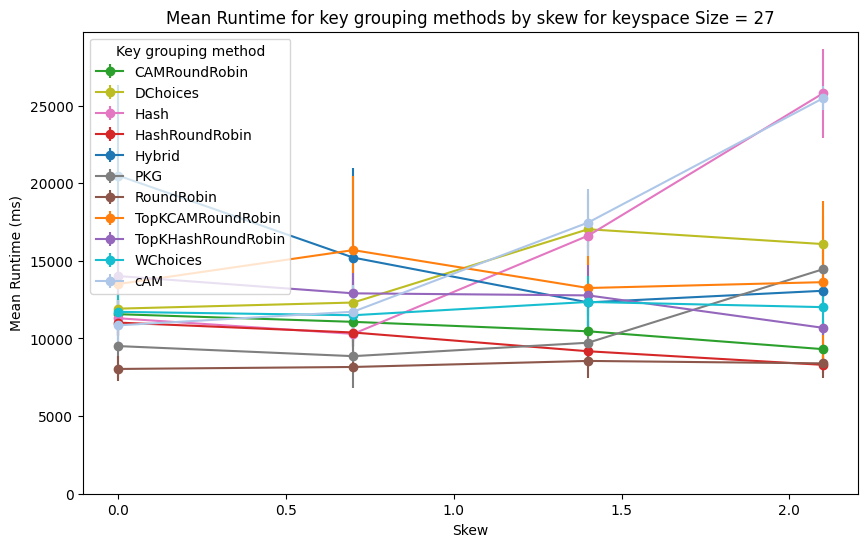

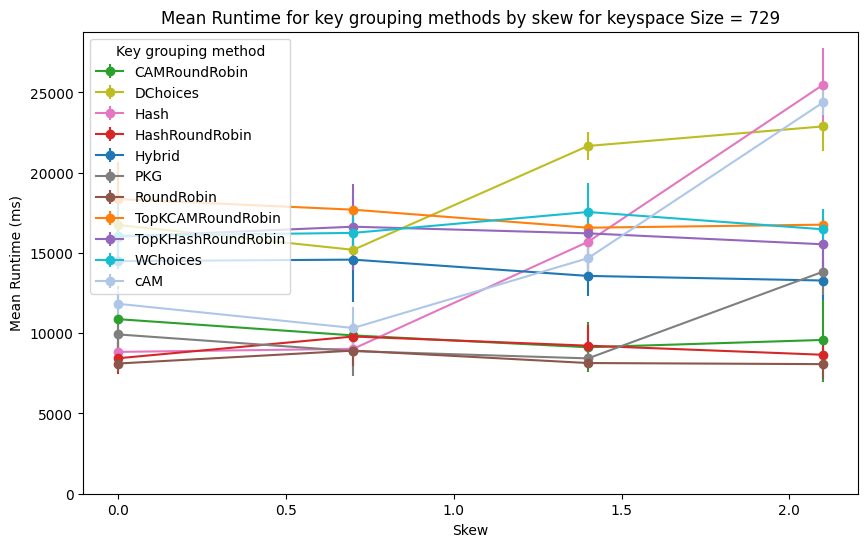

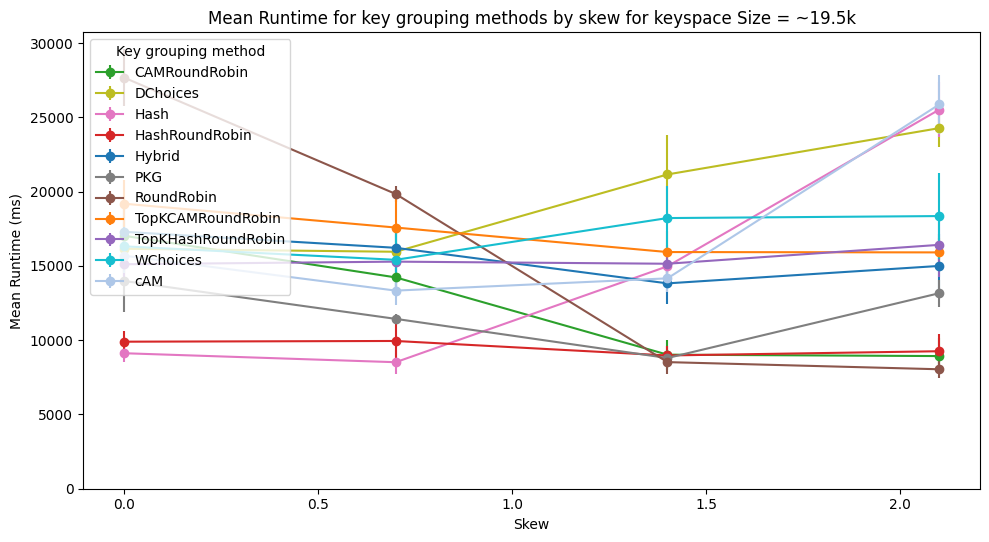

In [23]:
#PLOT FOR RUNTIME

for i in range(1,3+1):
    keysize_2_data = runtime_stats[runtime_stats['keySize'] == i].sort_values(by='skew')


    # Set up the plotting area
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot data for each operator
    for name, group in keysize_2_data.groupby('Operator'):
        if not group.empty:
            # print(group['skew'])
            ax.errorbar(group['skew'], group['mean runtime'], yerr=group['range']/2, fmt='-o', label=f'{name[4:]}',color = operator_colors.get(name, '#000000') )
        else:
            print(f"No data for Operator {name} with keySize == {i}")

    # Label the axes and the plot
    ax.set_xlabel('Skew')
    ax.set_ylabel('Mean Runtime (ms)')
    ax.set_title('Mean Runtime for key grouping methods by skew for keyspace Size = {}'.format(listOfKeySizes[i-1]))
    ax.legend(title='Key grouping method', loc='upper left')
     # Set the y-axis to start at 0
    ax.set_ylim(bottom=0)

    # Show the plot
    # plt.show()
    plt.savefig(experimentDirectory+"plot{}.png".format(i))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()



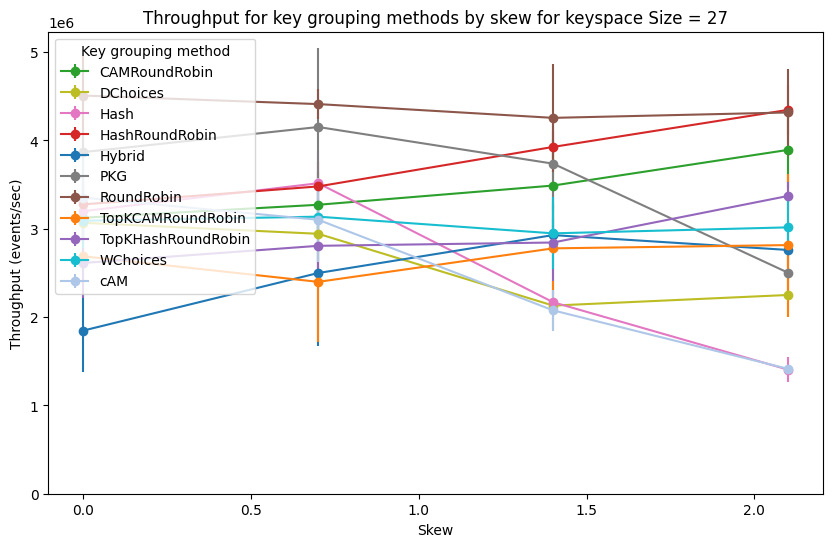

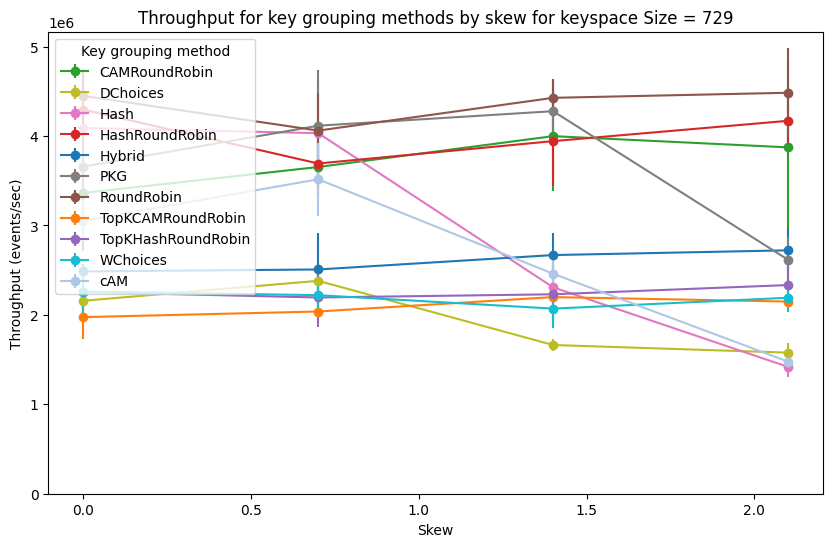

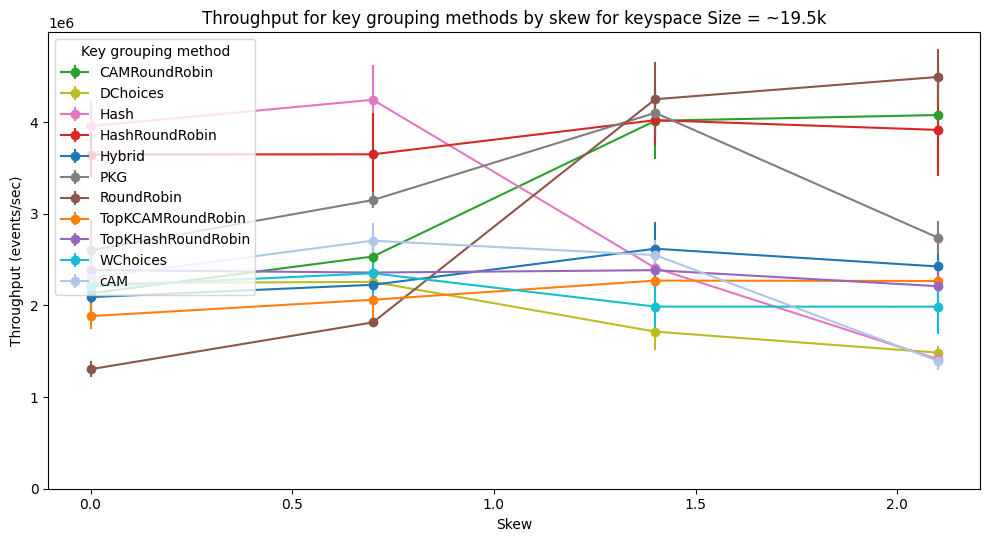

In [24]:
#PLOTS FOR THROUGHPUT
# Plot for Throughput

for i in range(1, 3+1):
    keysize_2_data = throughput_stats[throughput_stats['keySize'] == i].sort_values(by='skew')

    # Set up the plotting area
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot data for each operator
    for name, group in keysize_2_data.groupby('Operator'):
        if not group.empty:
            ax.errorbar(group['skew'], group['mean throughput'], yerr=group['range']/2, fmt='-o', label=f'{name[4:]}',color = operator_colors.get(name, '#000000') )
        else:
            print(f"No data for Operator {name} with keySize == {i}")

    # Label the axes and the plot
    ax.set_xlabel('Skew')
    ax.set_ylabel('Throughput (events/sec)')
    ax.set_title('Throughput for key grouping methods by skew for keyspace Size = {}'.format(listOfKeySizes[i-1]))
    ax.legend(title='Key grouping method', loc='upper left')
    # Set the y-axis to start at 0
    ax.set_ylim(bottom=0)

    # Show the plot
    plt.savefig("plot_throughput_{}.png".format(i))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


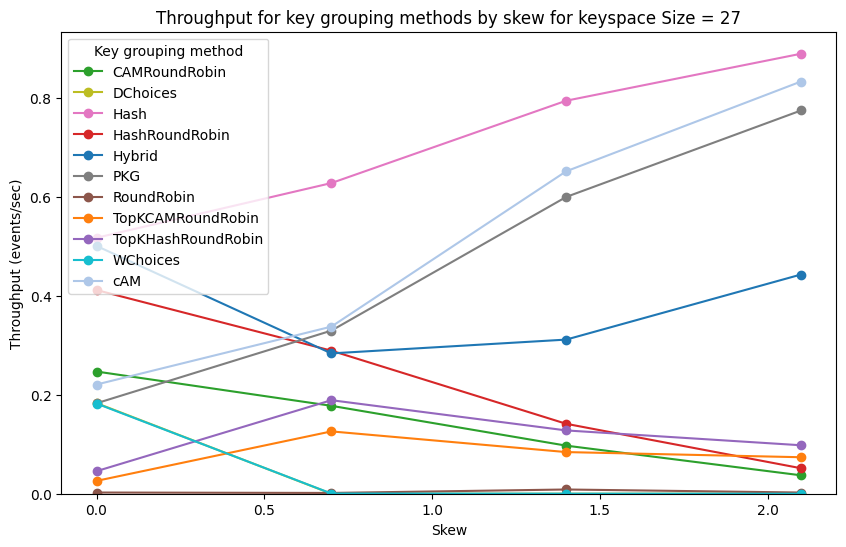

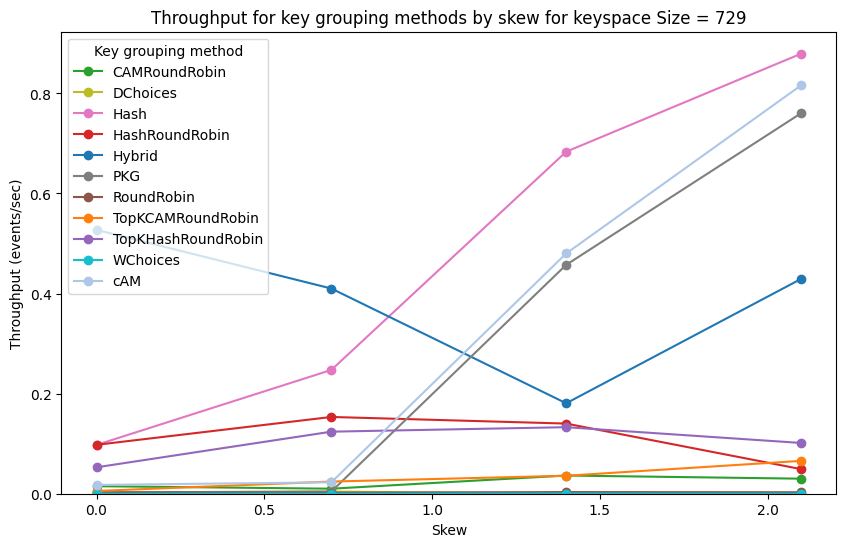

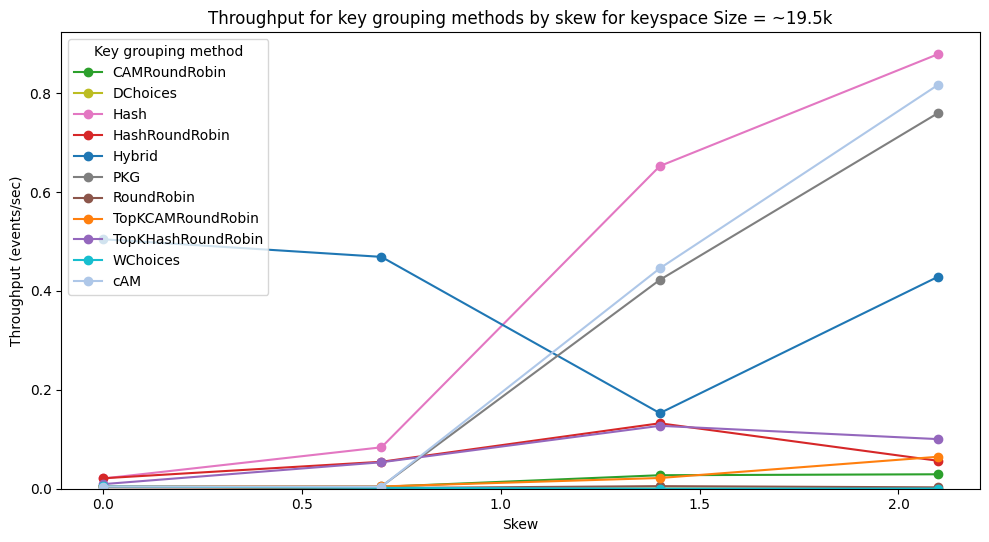

In [25]:
#PLOTS FOR GINI COEFFICIENT OF INTPUT
import gini as gini

loadDistribution = throughputExtraction.select_best_rows(main_metrics_df, ['PartialFunctionNumRecordsIn'])
loadDistribution['gini_coefficient'] = loadDistribution['PartialFunctionNumRecordsIn'].apply(gini.gini_index)
# print(loadDistribution['gini_coefficient'])
for i in range(1, 3+1):
    keysize_2_data = loadDistribution[loadDistribution['keySize'] == i].sort_values(by='skew')

    # Set up the plotting area
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot data for each operator
    for name, group in keysize_2_data.groupby('Operator'):
        if not group.empty:
            ax.errorbar(group['skew'], group['gini_coefficient'], fmt='-o', label=f'{name[4:]}',color = operator_colors.get(name, '#000000') )
        else:
            print(f"No data for Operator {name} with keySize == {i}")

    # Label the axes and the plot
    ax.set_xlabel('Skew')
    ax.set_ylabel('Throughput (events/sec)')
    ax.set_title('Throughput for key grouping methods by skew for keyspace Size = {}'.format(listOfKeySizes[i-1]))
    ax.legend(title='Key grouping method', loc='upper left')
    # Set the y-axis to start at 0
    ax.set_ylim(bottom=0)

    # Show the plot
    plt.savefig("plot_throughput_{}.png".format(i))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


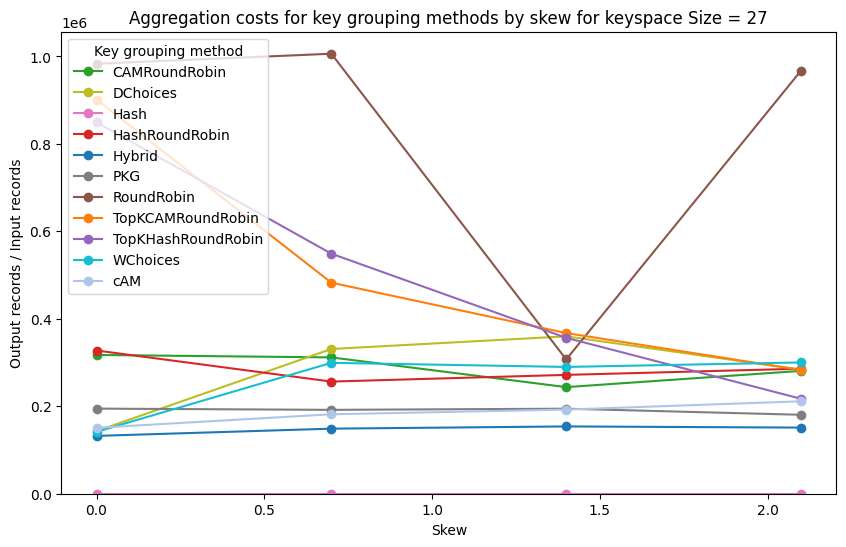

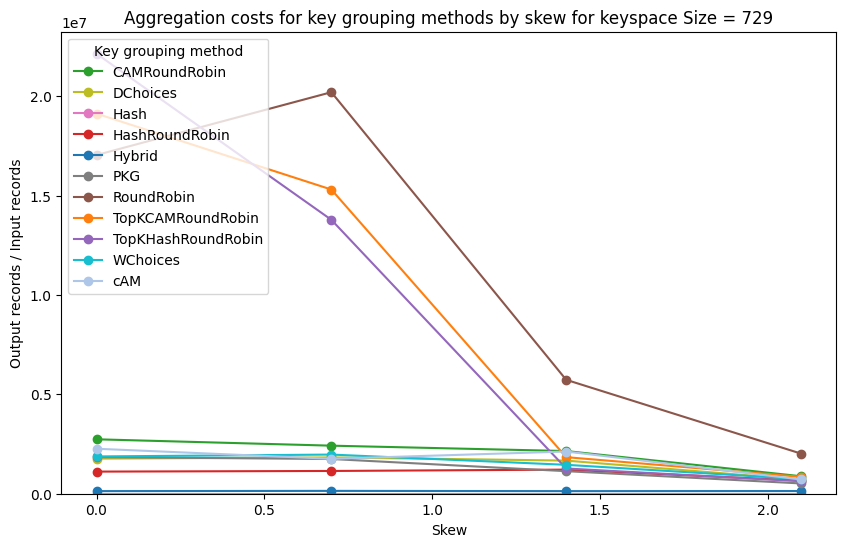

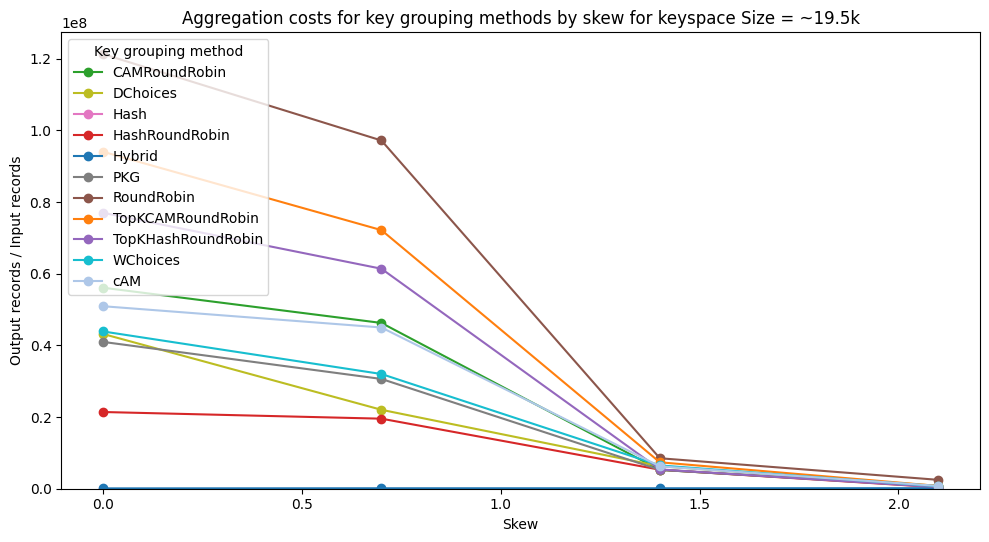

In [26]:
#PLOTS FOR INPUT TOTAL OUTPUT  /TOTAL THROUGHPUT
import specialSum as specialSum
aggregation_costs = throughputExtraction.select_best_rows(main_metrics_df, ['PartialFunctionNumRecordsIn','PartialFunctionNumRecordsOut'])

aggregation_costs['PartialFunctionNumRecordsIn']  = aggregation_costs['PartialFunctionNumRecordsIn'].apply(specialSum.specialSum)
aggregation_costs['PartialFunctionNumRecordsOut']  = aggregation_costs['PartialFunctionNumRecordsOut'].apply(specialSum.specialSum)
aggregation_costs['aggregationCosts'] = aggregation_costs['PartialFunctionNumRecordsOut']/ aggregation_costs['PartialFunctionNumRecordsIn']
mean_hybrid_rows = aggregation_costs[aggregation_costs['Operator'] == 'MeanHybrid']


for i in range(1, 3+1):
    keysize_2_data = aggregation_costs[aggregation_costs['keySize'] == i].sort_values(by='skew')

    # Set up the plotting area
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot data for each operator
    for name, group in keysize_2_data.groupby('Operator'):
        if not group.empty:
            ax.errorbar(group['skew'], group['aggregationCosts'], fmt='-o', label=f'{name[4:]}',color = operator_colors.get(name, '#000000') )
        else:
            print(f"No data for Operator {name} with keySize == {i}")

    # Label the axes and the plot
    ax.set_xlabel('Skew')
    ax.set_ylabel('Output records / Input records')
    ax.set_title('Aggregation costs for key grouping methods by skew for keyspace Size = {}'.format(listOfKeySizes[i-1]))
    ax.legend(title='Key grouping method', loc='upper left')
    # Set the y-axis to start at 0
    ax.set_ylim(bottom=0)

    # Show the plot
    plt.savefig("plot_throughput_{}.png".format(i))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [27]:
mean_hybrid_rows

,Operator,source_parallelism,main_parallelism,aggregator_parallelism,distributionType,eventPerWindow,amountOfWindows,keySize,skew,SourceAccumulate,SourceNumBytesIn,SourceNumBytesOut,SourceNumRecordsOut,SourceNumRecordsIn,PartialFunctionAccumulate,PartialFunctionNumBytesIn,PartialFunctionNumBytesOut,PartialFunctionNumRecordsOut,PartialFunctionNumRecordsIn,AggregatorAccumulate,AggregatorNumBytesIn,AggregatorNumBytesOut,AggregatorNumRecordsOut,AggregatorNumRecordsIn,aggregationCosts
48,MeanHybrid,6,6,1,zipf,100000,360,1,0.0,"[2191, 6236, 871, 6281, 6277, 6191]","[0, 0, 0, 0, 0, 0]","[143360000, 145522688, 262504448, 145883136, 145424384, 146079744]","[3155089, 3203998, 5774189, 3211423, 3199500, 3215140]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[104361459, 104361397, 104361321, 500660406, 250475772, 563282056]","[98304, 98304, 98304, 0, 0, 0]",6210,1627502411,[0],[306228],[0],[0],[306228],0.000004
49,MeanHybrid,6,6,1,zipf,100000,360,1,0.7,"[0, 0, 0, 0, 33, 0]","[0, 0, 0, 0, 0, 0]","[220463104, 91881472, 172589056, 103317504, 265191424, 258244608]","[4851452, 2024605, 3797240, 2276700, 5832331, 5678749]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[221249585, 221249549, 221249463, 321459258, 163973895, 313294018]","[65536, 65536, 65536, 0, 0, 0]",4086,1462475768,[0],[200556],[0],[0],[200556],0.000003
50,MeanHybrid,6,6,1,zipf,100000,360,1,1.4,"[217, 90, 205, 91, 90, 89]","[0, 0, 0, 0, 0, 0]","[268337152, 36700160, 252477440, 38371328, 37814272, 39026688]","[5901203, 811254, 5552708, 848240, 836318, 862535]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[407262377, 407229587, 407262282, 171222529, 79727560, 139954193]","[98304, 98304, 98304, 0, 0, 0]",5976,1612658528,[0],[294924],[0],[0],[294924],0.000004
51,MeanHybrid,6,6,1,zipf,100000,360,1,2.1,"[338, 2174, 2080, 2366, 1800, 2736]","[0, 0, 0, 0, 0, 0]","[263487488, 261586944, 259555328, 262864896, 260702208, 263520256]","[5794861, 5754178, 5709189, 5781133, 5733327, 5795593]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[484769816, 482836504, 484868120, 56721432, 21871980, 38382655]","[98304, 98304, 98304, 0, 0, 0]",6150,1569450507,[0],[303828],[0],[0],[303828],0.000004
52,MeanHybrid,6,6,1,zipf,100000,360,2,0.0,"[2290, 2268, 2277, 2354, 2339, 2346]","[0, 0, 0, 0, 0, 0]","[170328064, 173113344, 173015040, 173637632, 171474944, 168361984]","[3747132, 3809325, 3806759, 3820569, 3772126, 3703386]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[2603981, 2603824, 2603831, 306053144, 353140760, 360415256]","[32768, 32768, 32768, 0, 0, 0]",3978,1027420796,[0],[187823],[0],[0],[187823],0.000004
53,MeanHybrid,6,6,1,zipf,100000,360,2,0.7,"[1257, 1774, 1666, 1707, 1668, 1595]","[0, 0, 0, 0, 0, 0]","[260702208, 260046848, 260636672, 260734976, 260866048, 260308992]","[5733783, 5720398, 5732274, 5734135, 5737343, 5725983]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[69831905, 69831794, 69831829, 419059887, 435748888, 496730136]","[98304, 98304, 98304, 0, 0, 0]",6156,1561034439,[0],[301788],[0],[0],[301788],0.000004
54,MeanHybrid,6,6,1,zipf,100000,360,2,1.4,"[47, 73, 0, 44, 51, 0]","[0, 0, 0, 0, 0, 0]","[244219904, 245497856, 264077312, 215416832, 239206400, 259227648]","[5370808, 5399345, 5807550, 4739095, 5261014, 5700539]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[308412440, 308412440, 308412440, 198049816, 142901272, 200966168]","[65536, 65536, 65536, 0, 0, 0]",5106,1467154576,[0],[251427],[0],[0],[251427],0.000003
55,MeanHybrid,6,6,1,zipf,100000,360,2,2.1,"[3085, 3722, 3074, 3158, 3688, 3005]","[0, 0, 0, 0, 0, 0]","[268075008, 270139392, 268402688, 268304384, 270073856, 268075008]","[5896307, 5941044, 5903177, 5900768, 5940618, 5896052]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[487981080, 489947160, 489488408, 64066863, 30039840, 49053720]","[98304, 98304, 98304, 0, 0, 0]",6348,1610577071,[0],[314258],[0],[0],[314258],0.000004
56,MeanHybrid,6,6,1,zipf,100000,360,3,0.0,"[6991, 5135, 6676, 8565, 8573, 7304]","[0, 0, 0, 0, 0, 0]","[266797056, 266829824, 266403840, 268959744, 268894208, 26676428

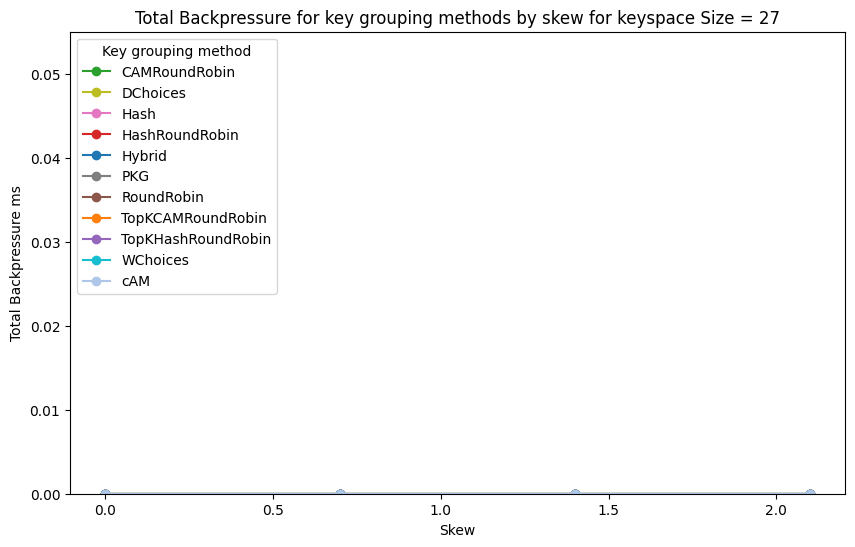

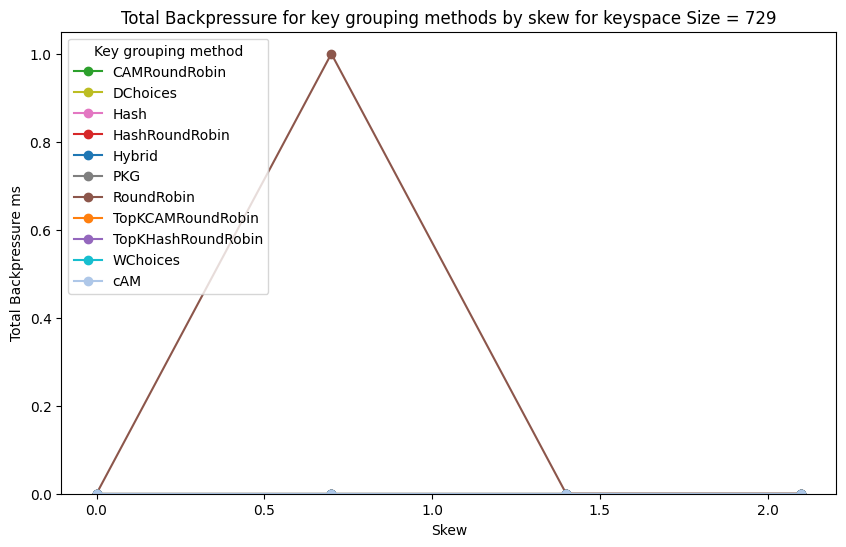

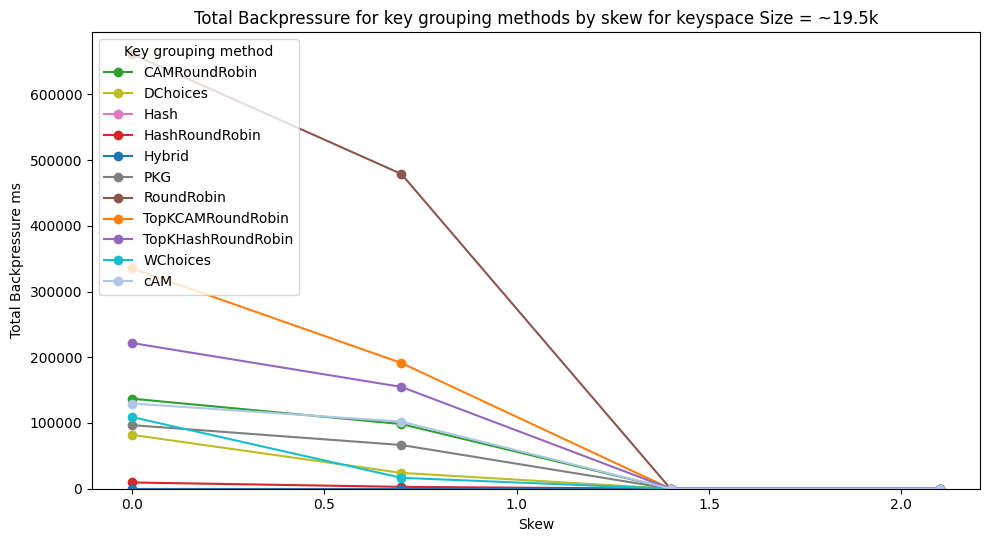

In [28]:
#PLOT FOR BACKPRESSURE AGGREGATION COSTS
import specialSum as specialSum
partialFunctionBackpressure = throughputExtraction.select_best_rows(main_metrics_df, ['PartialFunctionAccumulate'])

partialFunctionBackpressure['PartialFunctionAccumulate']  = partialFunctionBackpressure['PartialFunctionAccumulate'].apply(specialSum.specialSum)


for i in range(1, 3+1):
    keysize_2_data = partialFunctionBackpressure[partialFunctionBackpressure['keySize'] == i].sort_values(by='skew')

    # Set up the plotting area
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot data for each operator
    for name, group in keysize_2_data.groupby('Operator'):
        if not group.empty:
            ax.errorbar(group['skew'], group['PartialFunctionAccumulate'], fmt='-o', label=f'{name[4:]}',color = operator_colors.get(name, '#000000') )
        else:
            print(f"No data for Operator {name} with keySize == {i}")

    # Label the axes and the plot
    ax.set_xlabel('Skew')
    ax.set_ylabel('Total Backpressure ms')
    ax.set_title('Total Backpressure for key grouping methods by skew for keyspace Size = {}'.format(listOfKeySizes[i-1]))
    ax.legend(title='Key grouping method', loc='upper left')
    # Set the y-axis to start at 0
    ax.set_ylim(bottom=0)

    # Show the plot
    plt.savefig("plot_throughput_{}.png".format(i))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
